Mean Stability of all values: 0.9078680847076575
Based on 6795 stability values
consisting of 4289 observed + 2506 predicted stability values
Mean Stability of observed values: 0.9265737934250408
Mean Stability of predicted values: 0.8758534060608669
Correlation Coefficient of alldata values: 0.0779
p-value: 0.0000


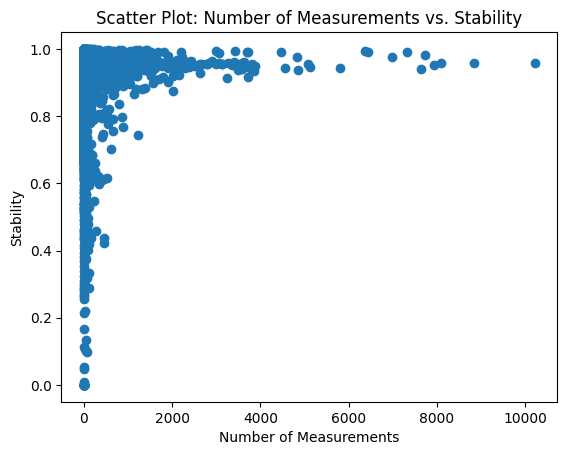

In [2]:
import sys
sys.path.append('../src')
import json
import matplotlib.pyplot as plt
from src.predictionHelper import add_predictions_gauss_regr
from src.mapCreator import filter_data_by_geometry
from src.mainController import MainController
from src.MapTypes import MapTypes
from scipy.stats import pearsonr

# Load the JSON data from a file
with open('../data/db.json') as f:
    json_data = json.load(f)

state_names = ['Baden-Württemberg', 'Bavaria', 'Berlin', 'Brandenburg', 'Bremen', 'Hamburg', 'North Rhine-Westphalia']

# Create a dictionary that maps each state to a unique ID
state_to_id = {state: i for i, state in enumerate(state_names)}


chosen_states = ["Baden-Württemberg", "Bavaria"]
special_ids = None

# Get the IDs of the selected states
chosen_states_ids = [state_to_id[state] for state in chosen_states]

# Filter data using GeoPandas
gdf = filter_data_by_geometry(json_data, chosen_states_ids, forexp=True)

# seems like mainController.setData(gdf, MapTypes.Gauss, special_ids) does not work
# run add_predictions_gauss_regr on the data to add column 'uncertainty'
mainController = MainController()
mainController.setData(gdf, MapTypes.Gauss, special_ids)
filtered_data = add_predictions_gauss_regr(mainController.dto.gdf)

# differ between observed and predicted values
filtered_observed = filtered_data[(filtered_data['uncertainty'].isnull())]
filtered_predicted = filtered_data[(filtered_data['uncertainty'].isnull()==False)]

# Calculate the average stability for each state for observed and predicted data
average_stability_all = filtered_data['all_stability'].mean()
total_stability_all = filtered_data['all_stability'].count()
average_stability_observed = filtered_observed['all_stability'].mean()
total_stability_observed = filtered_observed['all_stability'].count()
average_stability_predicted = filtered_predicted['all_stability'].mean()
total_stability_predicted = filtered_predicted['all_stability'].count()

print("Mean Stability of all values:", average_stability_all)
print(f'Based on {total_stability_all} stability values')
print(f'consisting of {total_stability_observed} observed + {total_stability_predicted} predicted stability values')
print("Mean Stability of observed values:", average_stability_observed)
print("Mean Stability of predicted values:", average_stability_predicted)

# Step 1a: Correlation Analysis of alldata
correlation_coefficient, p_value = pearsonr(filtered_data['all_measurements'], filtered_data['all_stability'])
print(f'Correlation Coefficient of alldata values: {correlation_coefficient:.4f}')
print(f'p-value: {p_value:.4f}')

# Step 2: Scatter Plot of alldata
plt.scatter(filtered_data['all_measurements'], filtered_data['all_stability'])
plt.xlabel('Number of Measurements')
plt.ylabel('Stability')
plt.title('Scatter Plot: Number of Measurements vs. Stability')
plt.show()

Mean Stability of observed values: 0.9265737934250408
Based on 4289 stability values
Correlation Coefficient of observed values: 0.0698
p-value: 0.0000


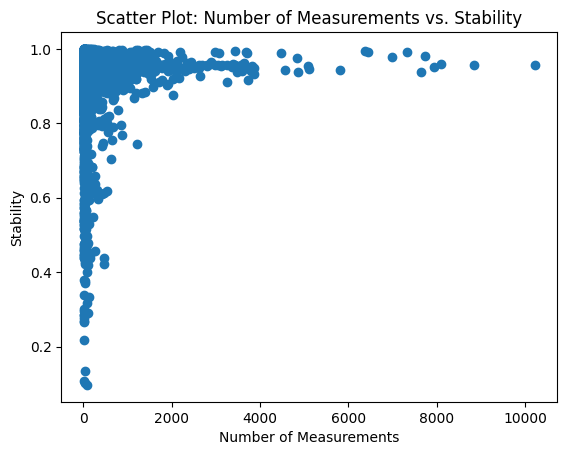

In [3]:
print("Mean Stability of observed values:", average_stability_observed)
print(f'Based on {total_stability_observed} stability values')
# Step 1a: Correlation Analysis of alldata
correlation_coefficient, p_value = pearsonr(filtered_observed['all_measurements'], filtered_observed['all_stability'])
print(f'Correlation Coefficient of observed values: {correlation_coefficient:.4f}')
print(f'p-value: {p_value:.4f}')
# Step 2a: Scatter Plot
plt.scatter(filtered_observed['all_measurements'], filtered_observed['all_stability'])
plt.xlabel('Number of Measurements')
plt.ylabel('Stability')
plt.title('Scatter Plot: Number of Measurements vs. Stability')
plt.show()

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
# Step 3: Simple Linear Regression
X = filtered_data[['all_measurements']]
y = filtered_data['all_stability']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Print the coefficients
print(f'Intercept: {model.intercept_:.4f}')
print(f'Coefficient (slope): {model.coef_[0]:.4f}')

Intercept: 0.9051
Coefficient (slope): 0.0000


In [5]:
import statsmodels.api as sm

# Add a constant term to the independent variable (Number_of_Measurements)
X = sm.add_constant(filtered_data['all_measurements'])

# Dependent variable
y = filtered_data['all_stability']

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Display the summary of the regression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          all_stability   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     41.46
Date:                Mon, 22 Jan 2024   Prob (F-statistic):           1.29e-10
Time:                        17:46:04   Log-Likelihood:                 4435.6
No. Observations:                6795   AIC:                            -8867.
Df Residuals:                    6793   BIC:                            -8854.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.9053      0.002  

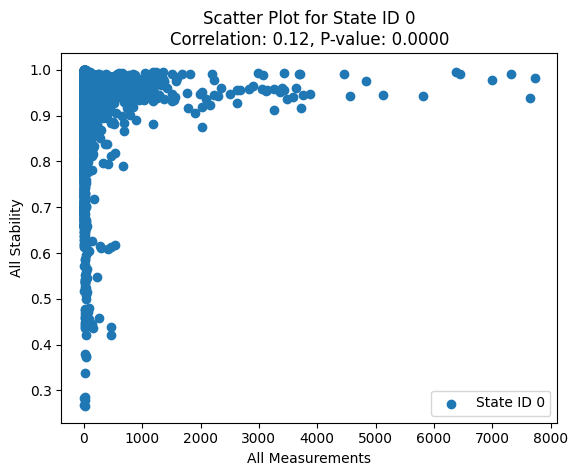

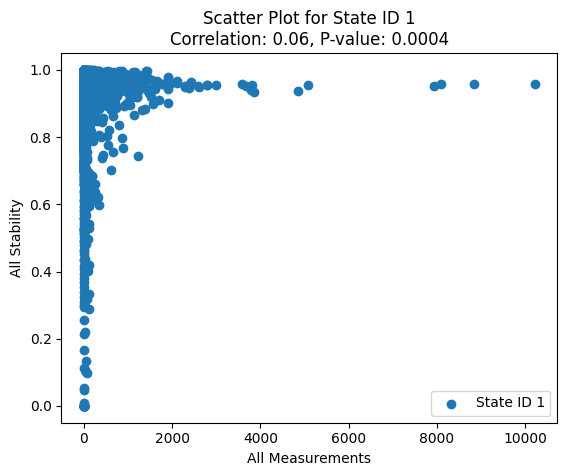

In [6]:
# Create a dictionary to store alldata values for each state ID
all_values = {}

# Iterate over the alldata DataFrame and populate the dictionary
for index, row in filtered_data.iterrows():
    state_id = row['state_id']
    all_measurements = row['all_measurements']
    all_stability = row['all_stability']
    
    # Check if the state_id is already in the dictionary
    if state_id not in all_values:
        all_values[state_id] = []
    
    # Append a tuple containing measurements and stability to the list
    all_values[state_id].append((all_measurements, all_stability))

for state_id, group_data in filtered_data.groupby('state_id'):
    all_measurements = group_data['all_measurements']
    all_stability = group_data['all_stability']
    
    # Calculate the Pearson correlation coefficient and p-value
    correlation_coefficient, p_value = pearsonr(all_measurements, all_stability)
    
    # Append results to the dictionary
    all_values[state_id] = {
        'measurements': all_measurements.tolist(),
        'stability': all_stability.tolist(),
        'correlation_coefficient': correlation_coefficient,
        'p_value': p_value
    }

    # Create scatter plot
    plt.scatter(all_measurements, all_stability, label=f"State ID {state_id}")
    plt.xlabel('All Measurements')
    plt.ylabel('All Stability')
    plt.title(f'Scatter Plot for State ID {state_id}\nCorrelation: {correlation_coefficient:.2f}, P-value: {p_value:.4f}')
    plt.legend()
    plt.show()

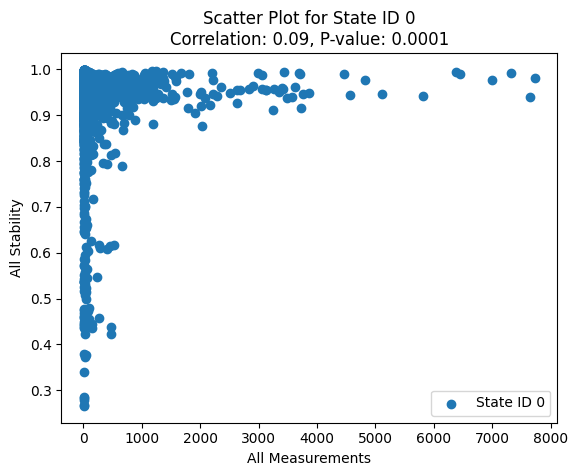

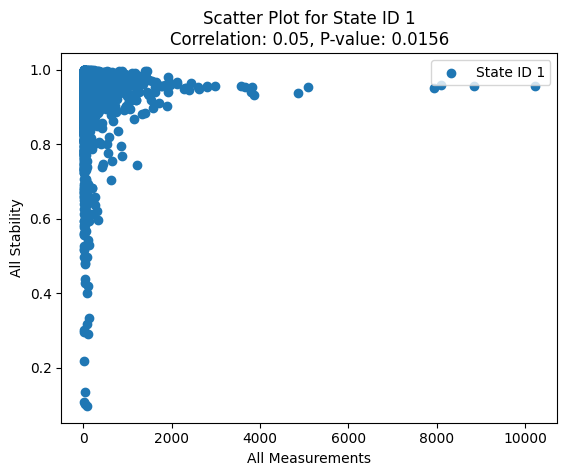

In [7]:
# Create a dictionary to store observed values for each state ID
observed_values = {}

# Iterate over the observed DataFrame and populate the dictionary
for index, row in filtered_observed.iterrows():
    state_id = row['state_id']
    all_measurements = row['all_measurements']
    all_stability = row['all_stability']
    
    # Check if the state_id is already in the dictionary
    if state_id not in observed_values:
        observed_values[state_id] = []
    
    # Append a tuple containing measurements and stability to the list
    observed_values[state_id].append((all_measurements, all_stability))

for state_id, group_data in filtered_observed.groupby('state_id'):
    all_measurements = group_data['all_measurements']
    all_stability = group_data['all_stability']
    
    # Calculate the Pearson correlation coefficient and p-value
    correlation_coefficient, p_value = pearsonr(all_measurements, all_stability)
    
    # Append results to the dictionary
    observed_values[state_id] = {
        'measurements': all_measurements.tolist(),
        'stability': all_stability.tolist(),
        'correlation_coefficient': correlation_coefficient,
        'p_value': p_value
    }

    # Create scatter plot
    plt.scatter(all_measurements, all_stability, label=f"State ID {state_id}")
    plt.xlabel('All Measurements')
    plt.ylabel('All Stability')
    plt.title(f'Scatter Plot for State ID {state_id}\nCorrelation: {correlation_coefficient:.2f}, P-value: {p_value:.4f}')
    plt.legend()
    plt.show()

In [8]:
mainController = MainController()
mainController.setData(gdf, MapTypes.StabilityWithEmptyMeasures, special_ids)

average_stability_unprocessed = mainController.dto.gdf['all_stability'].mean()
total_stability_all_unprocessed = mainController.dto.gdf['all_stability'].count()
total_stability_all_unprocessed_null_values = mainController.dto.gdf[mainController.dto.gdf['all_measurements'] == 0]['all_stability'].count()
total_stability_all_unprocessed_notnull_values = mainController.dto.gdf[mainController.dto.gdf['all_measurements'] != 0]['all_stability'].count()
measurement_coverage = total_stability_all_unprocessed_notnull_values / total_stability_all_unprocessed

print(average_stability_unprocessed)
print(total_stability_all_unprocessed)
print(f'Based on {total_stability_all_unprocessed_notnull_values} datapoints with measurements and {total_stability_all_unprocessed_null_values} without measurements')
print(f'With a measurement coverage of {measurement_coverage:.4f}')

0.5848528329654157
6795
Based on 4289 datapoints with measurements and 2506 without measurements
With a measurement coverage of 0.6312


In [9]:
# Create a dictionary to store observed values for each state ID
all_values = {}

for index, row in mainController.dto.gdf.iterrows():
    state_id = row['state_id']
    all_measurements = row['all_measurements']
    all_stability = row['all_stability']
    
    # Check if the state_id is already in the dictionary
    if state_id not in all_values:
        all_values[state_id] = []
    
    # Append a tuple containing measurements and stability to the list
    all_values[state_id].append((all_measurements, all_stability))

# Print the observed values for each state ID
for state_id, measurements in all_values.items():
    print(f"State ID: {state_id}, Measurements, Stability: {measurements}, {all_stability}")

State ID: 0, Measurements, Stability: [(1993, 0.947), (1288, 0.946), (942, 0.951), (724, 0.957), (529, 0.957), (423, 0.952), (378, 0.94), (328, 0.933), (247, 0.934), (208, 0.939), (198, 0.943), (529, 0.951), (498, 0.941), (454, 0.935), (392, 0.938), (334, 0.938), (293, 0.932), (285, 0.921), (308, 0.898), (391, 0.838), (414, 0.794), (330, 0.796), (225, 0.868), (188, 0.906), (183, 0.928), (194, 0.941), (296, 0.966), (241, 0.974), (208, 0.978), (176, 0.98), (142, 0.981), (112, 0.981), (88, 0.98), (68, 0.979), (53, 0.977), (44, 0.975), (44, 0.971), (52, 0.965), (55, 0.969), (55, 0.981), (49, 0.985), (37, 0.982), (28, 0.976), (22, 0.976), (17, 0.972), (18, 0.973), (31, 0.977), (53, 0.976), (51, 0.974), (33, 0.974), (25, 0.974), (21, 0.969), (21, 0.963), (26, 0.962), (39, 0.961), (68, 0.962), (133, 0.957), (606, 0.983), (1096, 0.983), (1046, 0.981), (484, 0.98), (261, 0.976), (148, 0.97), (87, 0.968), (58, 0.975), (44, 0.978), (35, 0.979), (30, 0.98), (26, 0.98), (24, 0.977), (24, 0.973), (2

Correlation Coefficient of the unprocessed data: 0.2063
p-value: 0.0000


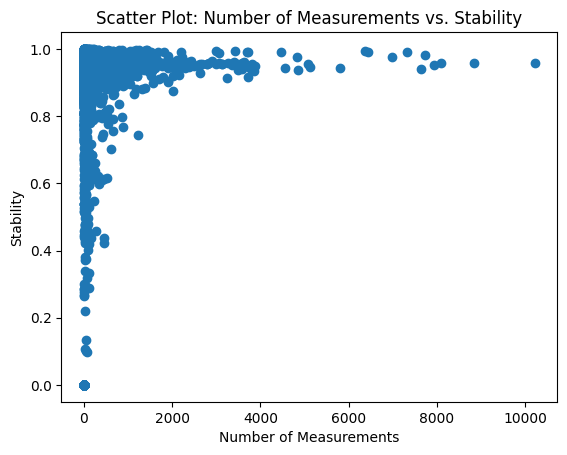

In [10]:
# Step 1a: Correlation Analysis of alldata
correlation_coefficient, p_value = pearsonr(mainController.dto.gdf['all_measurements'], mainController.dto.gdf['all_stability'])
print(f'Correlation Coefficient of the unprocessed data: {correlation_coefficient:.4f}')
print(f'p-value: {p_value:.4f}')

# Step 2: Scatter Plot of alldata
plt.scatter(mainController.dto.gdf['all_measurements'], mainController.dto.gdf['all_stability'])
plt.xlabel('Number of Measurements')
plt.ylabel('Stability')
plt.title('Scatter Plot: Number of Measurements vs. Stability')
plt.show()